# 赛题分析

本题要求根据给出的训练集建立流失预测模型来预测可能流失的客户，最终给出一个概率值，而且评测指标是典型的二分类评测指标AUC。

AUC：
- AUC反映模型对正负样本排序的质量
- 根据定义，理论上所有正样本排在负样本之前，AUC为最大值1.0

$$ AUC={ \sum_{i \in postive  Class}rank_{i} - {M(1+M) \over 2} \over {M * N} }$$

# 特征抽取

特征抽取的思路可能有以下三个角度：

- 从用户的历史出发，看各个特征的分布情况
- 从用户和是否流失的特征结合出发，统计特征分布情况

# 模型

- 常用分类算法：NB，决策树，SVM，KNN，LR
- 集成学习：RF，GBDT，Adaboot，XGBoost，LightGBM，CatBoost
- 神经网络：MLP，DNN

# 数据探索

我们可以明显看出来本题给出的数据没有缺失值，所以可以直接跳过处理缺失值的部分。

也不存在样本不均衡的情况，所以也可跳过这部分的处理。

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [13]:
plt.rcParams['font.family'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False

In [72]:
data_train = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')
data_train.info()
print("-" * 60)
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 69 columns):
 #   Column                 Non-Null Count   Dtype
---  ------                 --------------   -----
 0   客户ID                   150000 non-null  int64
 1   地理区域                   150000 non-null  int64
 2   是否双频                   150000 non-null  int64
 3   是否翻新机                  150000 non-null  int64
 4   当前手机价格                 150000 non-null  int64
 5   手机网络功能                 150000 non-null  int64
 6   婚姻状况                   150000 non-null  int64
 7   家庭成人人数                 150000 non-null  int64
 8   信息库匹配                  150000 non-null  int64
 9   预计收入                   150000 non-null  int64
 10  信用卡指示器                 150000 non-null  int64
 11  当前设备使用天数               150000 non-null  int64
 12  在职总月数                  150000 non-null  int64
 13  家庭中唯一订阅者的数量            150000 non-null  int64
 14  家庭活跃用户数                150000 non-null  int64
 15  新手机用户            

In [73]:
data_train.head()

,客户ID,地理区域,是否双频,是否翻新机,当前手机价格,手机网络功能,婚姻状况,家庭成人人数,信息库匹配,预计收入,...,客户生命周期内平均月费用,客户生命周期内的平均每月使用分钟数,客户整个生命周期内的平均每月通话次数,过去三个月的平均每月使用分钟数,过去三个月的平均每月通话次数,过去三个月的平均月费用,过去六个月的平均每月使用分钟数,过去六个月的平均每月通话次数,过去六个月的平均月费用,是否流失
0,0,7,0,-1,181,0,2,0,0,3,...,24,286,91,351,121,23,303,101,25,0
1,1,13,1,0,1399,0,3,0,0,0,...,44,447,190,483,199,40,488,202,44,1
2,2,14,1,0,927,0,2,4,0,6,...,48,183,79,271,95,71,209,77,54,0
3,3,1,0,0,232,0,3,-1,1,-1,...,42,303,166,473,226,72,446,219,65,1
4,4,0,-1,0,699,0,1,2,0,3,...,36,119,24,88,15,35,106,21,37,1


地理区域，是否双频，是否翻新机，手机网络功能，婚姻状况，信息库匹配，预计收入等等应该都是类别特征

In [7]:
data_train.describe()

,客户ID,地理区域,是否双频,是否翻新机,当前手机价格,手机网络功能,婚姻状况,家庭成人人数,信息库匹配,预计收入,...,客户生命周期内平均月费用,客户生命周期内的平均每月使用分钟数,客户整个生命周期内的平均每月通话次数,过去三个月的平均每月使用分钟数,过去三个月的平均每月通话次数,过去三个月的平均月费用,过去六个月的平均每月使用分钟数,过去六个月的平均每月通话次数,过去六个月的平均月费用,是否流失
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,...,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000
mean,74999.500000,8.060327,0.618253,-0.094287,705.279413,0.286100,1.629427,1.582027,0.136187,3.906173,...,56.727240,479.829973,171.989867,515.756253,179.328827,58.243247,492.528440,172.607533,56.273753,0.500280
std,43301.414527,5.065028,0.539597,0.292228,419.211310,0.587749,1.231911,1.714654,0.346488,3.156789,...,34.368247,427.972362,163.881701,520.295608,187.742919,43.516844,486.577663,178.694606,39.150687,0.500002
min,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-1.000000,-1.000000,-1.000000,0.000000
25%,37499.750000,4.000000,0.000000,0.000000,225.000000,0.000000,1.000000,0.000000,0.000000,1.000000,...,35.000000,177.000000,64.000000,154.000000,56.000000,33.000000,150.000000,55.000000,34.000000,0.000000
50%,74999.500000,8.000000,1.000000,0.000000,699.000000,0.000000,1.000000,1.000000,0.000000,5.000000,...,49.000000,361.000000,127.000000,358.000000,126.000000,48.000000,350.000000,123.000000,48.000000,1.000000
75%,112499.250000,12.000000,1.000000,0.000000,1049.000000,0.000000,3.000000,3.000000,0.000000,6.000000,...,68.000000,655.000000,227.000000,708.000000,239.000000,69.000000,681.000000,232.000000,68.000000,1.000000
max,149999.000000,18.000000,1.000000,0.000000,3499.000000,2.000000,4.000000,6.000000,1.000000,9.000000,...,902.000000,7040.000000,2716.000000,7716.000000,3261.000000,1593.000000,7217.000000,2887.000000,866.000000,1.000000


<AxesSubplot:xlabel='是否流失', ylabel='count'>

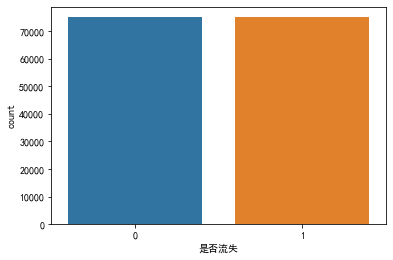

In [74]:
sns.countplot(x=data_train['是否流失'])

In [21]:
data_train.columns

Index(['客户ID', '地理区域', '是否双频', '是否翻新机', '当前手机价格', '手机网络功能', '婚姻状况', '家庭成人人数',
       '信息库匹配', '预计收入', '信用卡指示器', '当前设备使用天数', '在职总月数', '家庭中唯一订阅者的数量',
       '家庭活跃用户数', '新手机用户', '信用等级代码', '平均月费用', '每月平均使用分钟数', '平均超额使用分钟数',
       '平均超额费用', '平均语音费用', '数据超载的平均费用', '平均漫游呼叫数', '当月使用分钟数与前三个月平均值的百分比变化',
       '当月费用与前三个月平均值的百分比变化', '平均掉线语音呼叫数', '平均丢弃数据呼叫数', '平均占线语音呼叫数',
       '平均占线数据调用次数', '平均未接语音呼叫数', '未应答数据呼叫的平均次数', '尝试拨打的平均语音呼叫次数',
       '尝试数据调用的平均数', '平均接听语音电话数', '平均完成的语音呼叫数', '完成数据调用的平均数', '平均客户服务电话次数',
       '使用客户服务电话的平均分钟数', '一分钟内的平均呼入电话数', '平均三通电话数', '已完成语音通话的平均使用分钟数',
       '平均呼入和呼出高峰语音呼叫数', '平均峰值数据调用次数', '使用高峰语音通话的平均不完整分钟数', '平均非高峰语音呼叫数',
       '非高峰数据呼叫的平均数量', '平均掉线或占线呼叫数', '平均尝试调用次数', '平均已完成呼叫数', '平均呼叫转移呼叫数',
       '平均呼叫等待呼叫数', '账户消费限额', '客户生命周期内的总通话次数', '客户生命周期内的总使用分钟数', '客户生命周期内的总费用',
       '计费调整后的总费用', '计费调整后的总分钟数', '计费调整后的呼叫总数', '客户生命周期内平均月费用',
       '客户生命周期内的平均每月使用分钟数', '客户整个生命周期内的平均每月通话次数', '过去三个月的平均每月使用分钟数',
       '过去三个月的平均每月通话次数', '过去三个月的平均月费用', '过去六个月的平均每月使用分钟数', '过

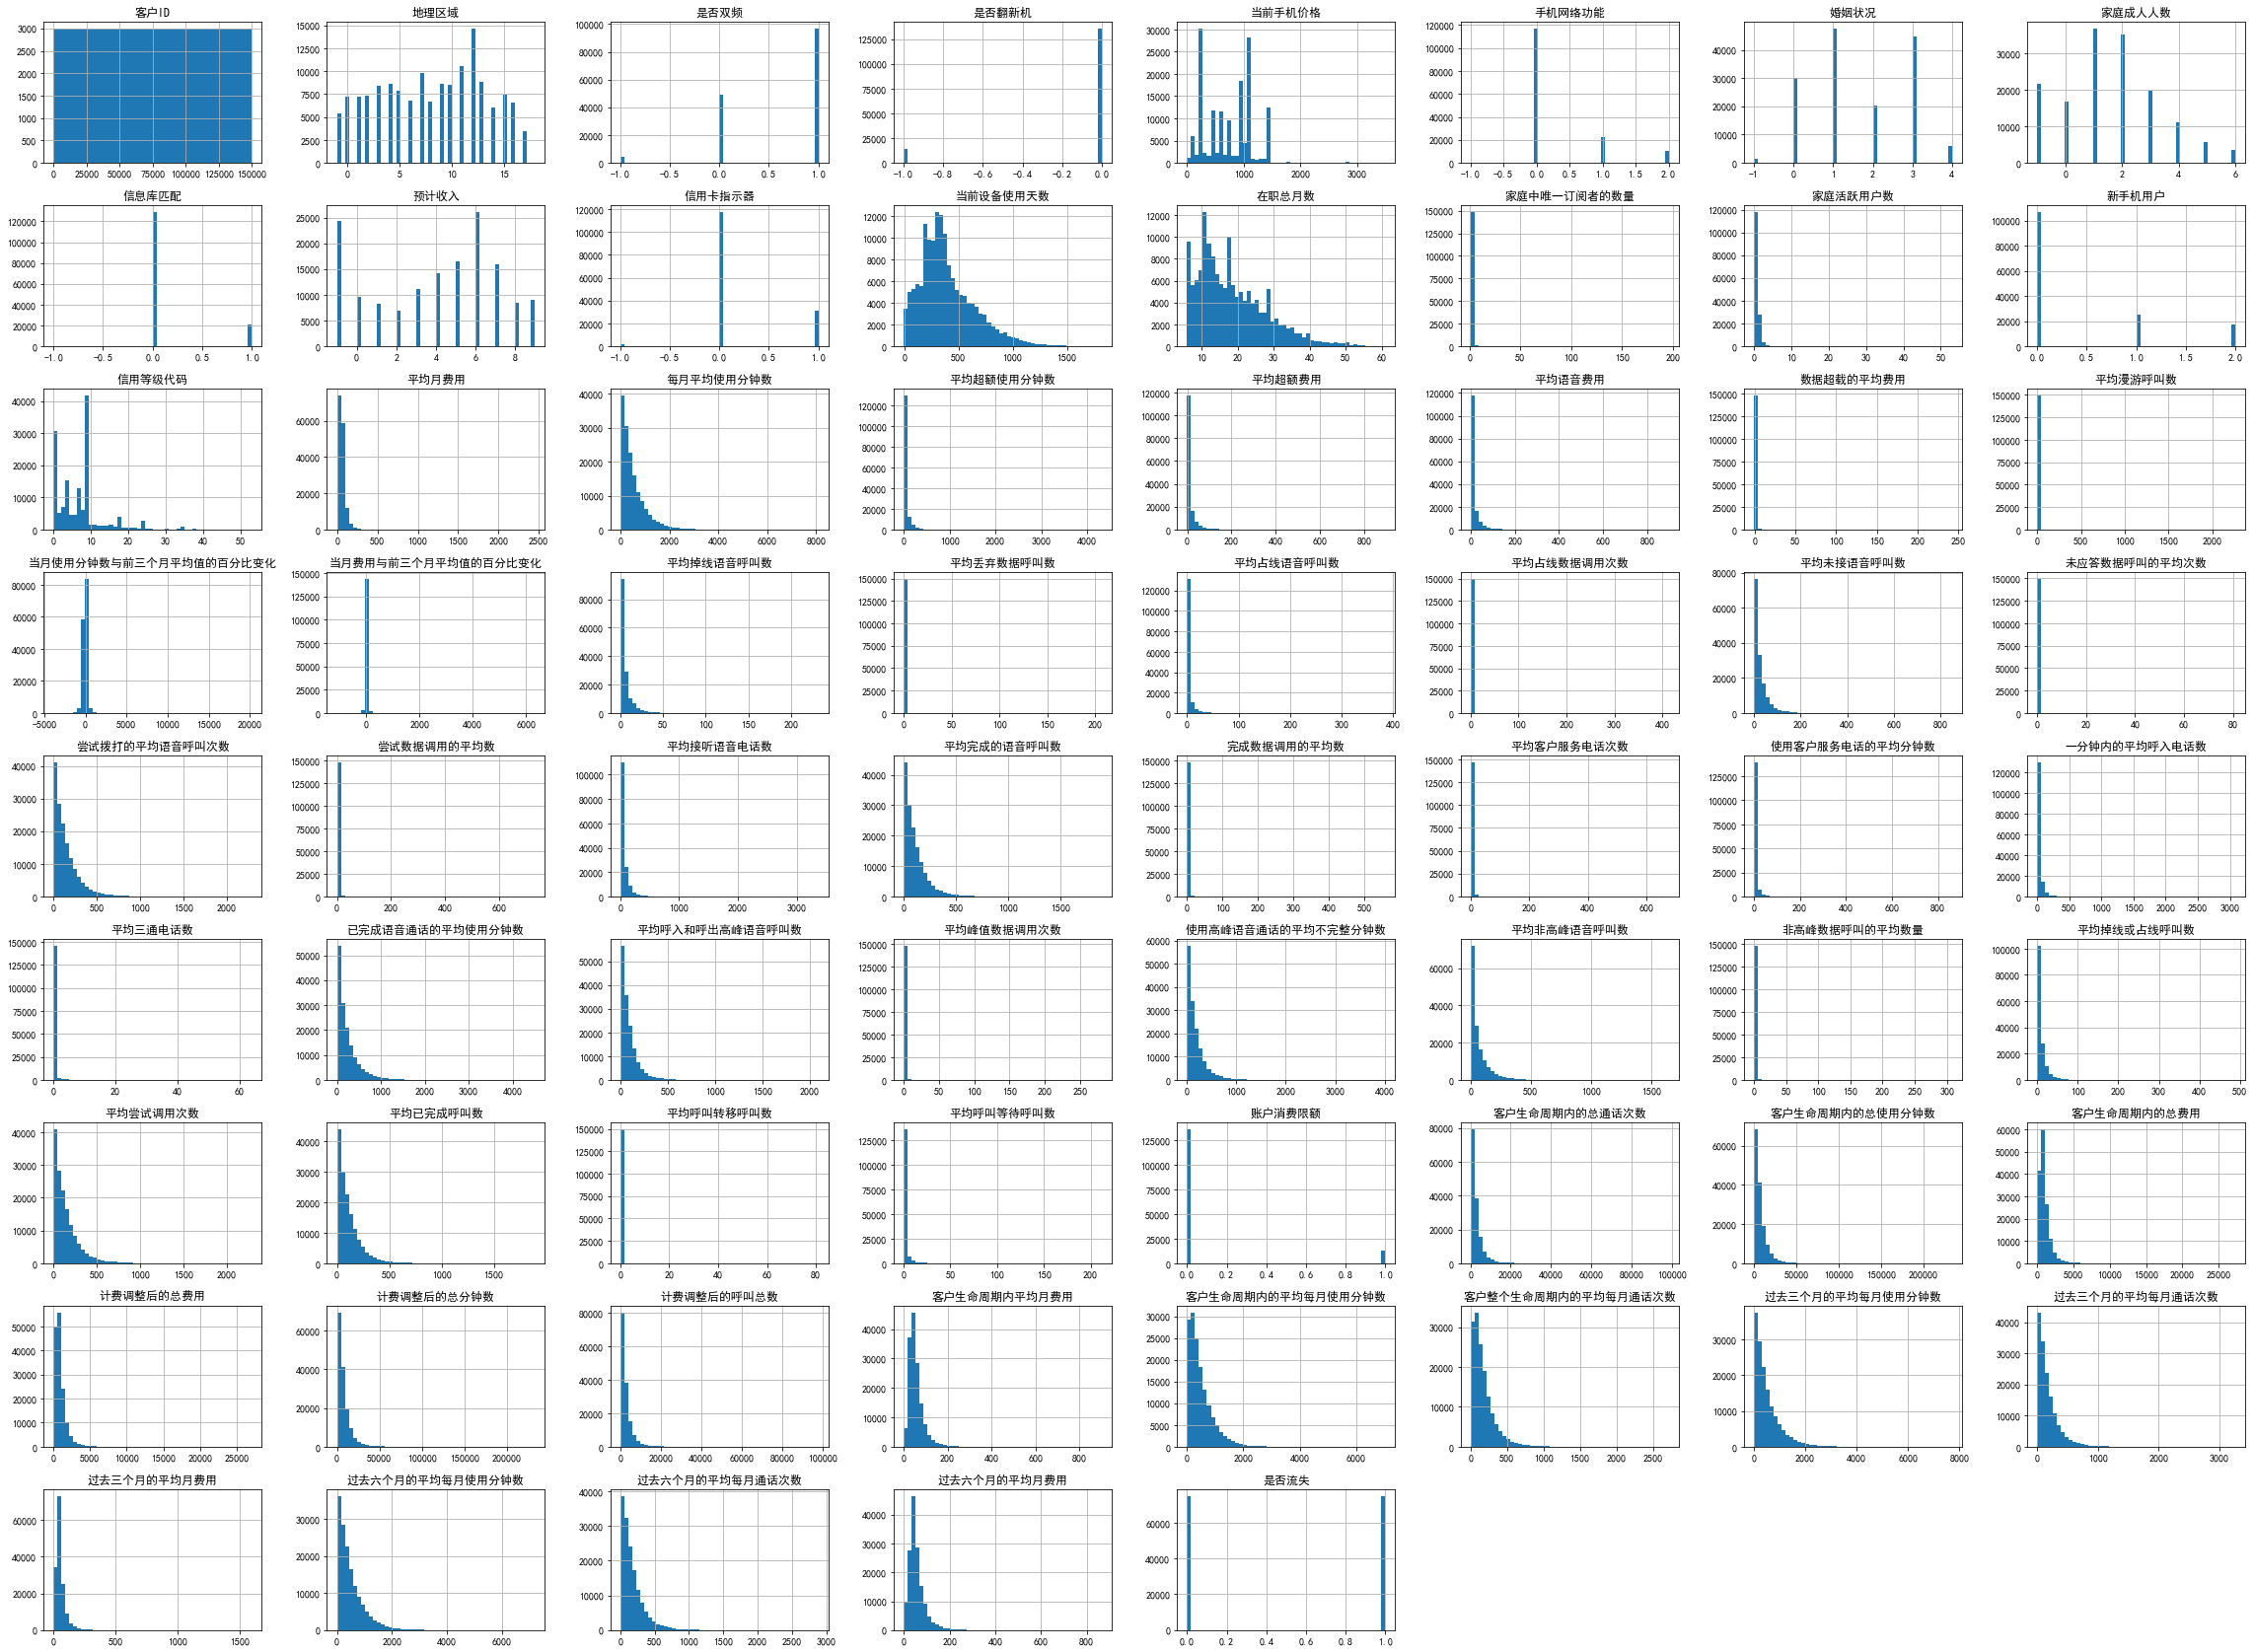

In [34]:
data_train.hist(bins=50, figsize=(40,30))
plt.show()

地理区域会不会有关系（因为我们实际生活中不同地区运营商有差距）

<AxesSubplot:xlabel='地理区域'>

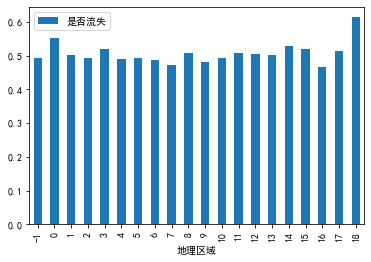

In [50]:
data_train[['是否流失','地理区域']].groupby(['地理区域']).mean().plot.bar()

<AxesSubplot:xlabel='地理区域', ylabel='count'>

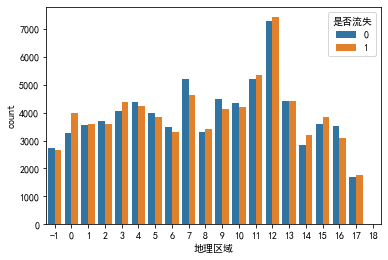

In [79]:
sns.countplot(data=data_train , x='地理区域', hue='是否流失')

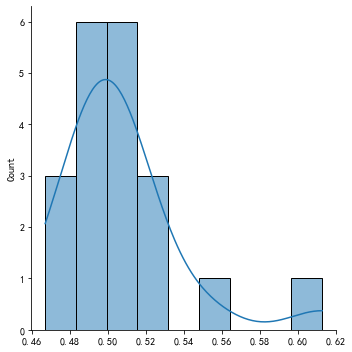

In [83]:
from scipy import stats
customer_churn = [rate for rate in data_train.groupby(['地理区域'])['是否流失'].mean() if rate<=1 and rate>0]
sns.displot(customer_churn, kde=True)

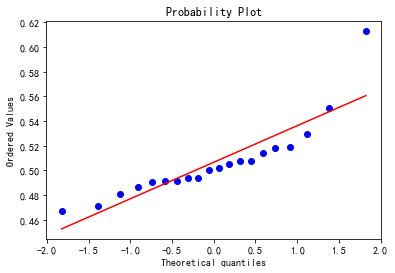

In [84]:
res = stats.probplot(customer_churn, plot=plt)

In [85]:
customer_churn

[0.49347501864280385,
 0.5504966887417219,
 0.5021626901074369,
 0.49383899233296824,
 0.518826463950588,
 0.4906362684657439,
 0.49127499681569226,
 0.4864784985961283,
 0.4708638956805216,
 0.5076785448039361,
 0.48077146508655744,
 0.4914065240266573,
 0.5074555988223003,
 0.5048073644732356,
 0.5005086469989827,
 0.52934350132626,
 0.517830709191226,
 0.46694902435335045,
 0.5138969310943833,
 0.6129032258064516]

In [87]:
data_train_region18 = data_train.loc[data_train['地理区域'] == 18]
data_train_region18

,客户ID,地理区域,是否双频,是否翻新机,当前手机价格,手机网络功能,婚姻状况,家庭成人人数,信息库匹配,预计收入,...,客户生命周期内平均月费用,客户生命周期内的平均每月使用分钟数,客户整个生命周期内的平均每月通话次数,过去三个月的平均每月使用分钟数,过去三个月的平均每月通话次数,过去三个月的平均月费用,过去六个月的平均每月使用分钟数,过去六个月的平均每月通话次数,过去六个月的平均月费用,是否流失
8613,8613,18,1,-1,209,0,1,1,0,5,...,38,246,100,387,138,43,331,121,38,1
8630,8630,18,1,0,419,0,1,4,0,4,...,12,173,64,133,58,10,150,57,10,1
12073,12073,18,1,0,909,0,1,2,0,9,...,42,152,73,269,118,41,223,99,42,0
21776,21776,18,1,0,419,0,1,2,0,6,...,32,103,65,78,57,32,78,54,31,1
29481,29481,18,1,-1,209,0,0,2,0,3,...,39,269,86,236,98,31,252,80,33,1
35734,35734,18,1,0,1049,0,1,4,0,6,...,62,415,121,210,95,57,285,94,63,0
39278,39278,18,1,-1,209,0,1,6,0,7,...,95,375,111,58,23,53,127,44,62,0
42297,42297,18,1,0,909,0,1,5,0,9,...,50,533,205,878,313,60,832,294,61,1
68190,68190,18,1,-1,559,0,3,-1,1,-1,...,64,1274,359,1472,435,61,1487,421,68,1
72251,72251,18,0,0,419,1,1,3,0,8,...,41,161,58,23,9,35,20,9,36,1


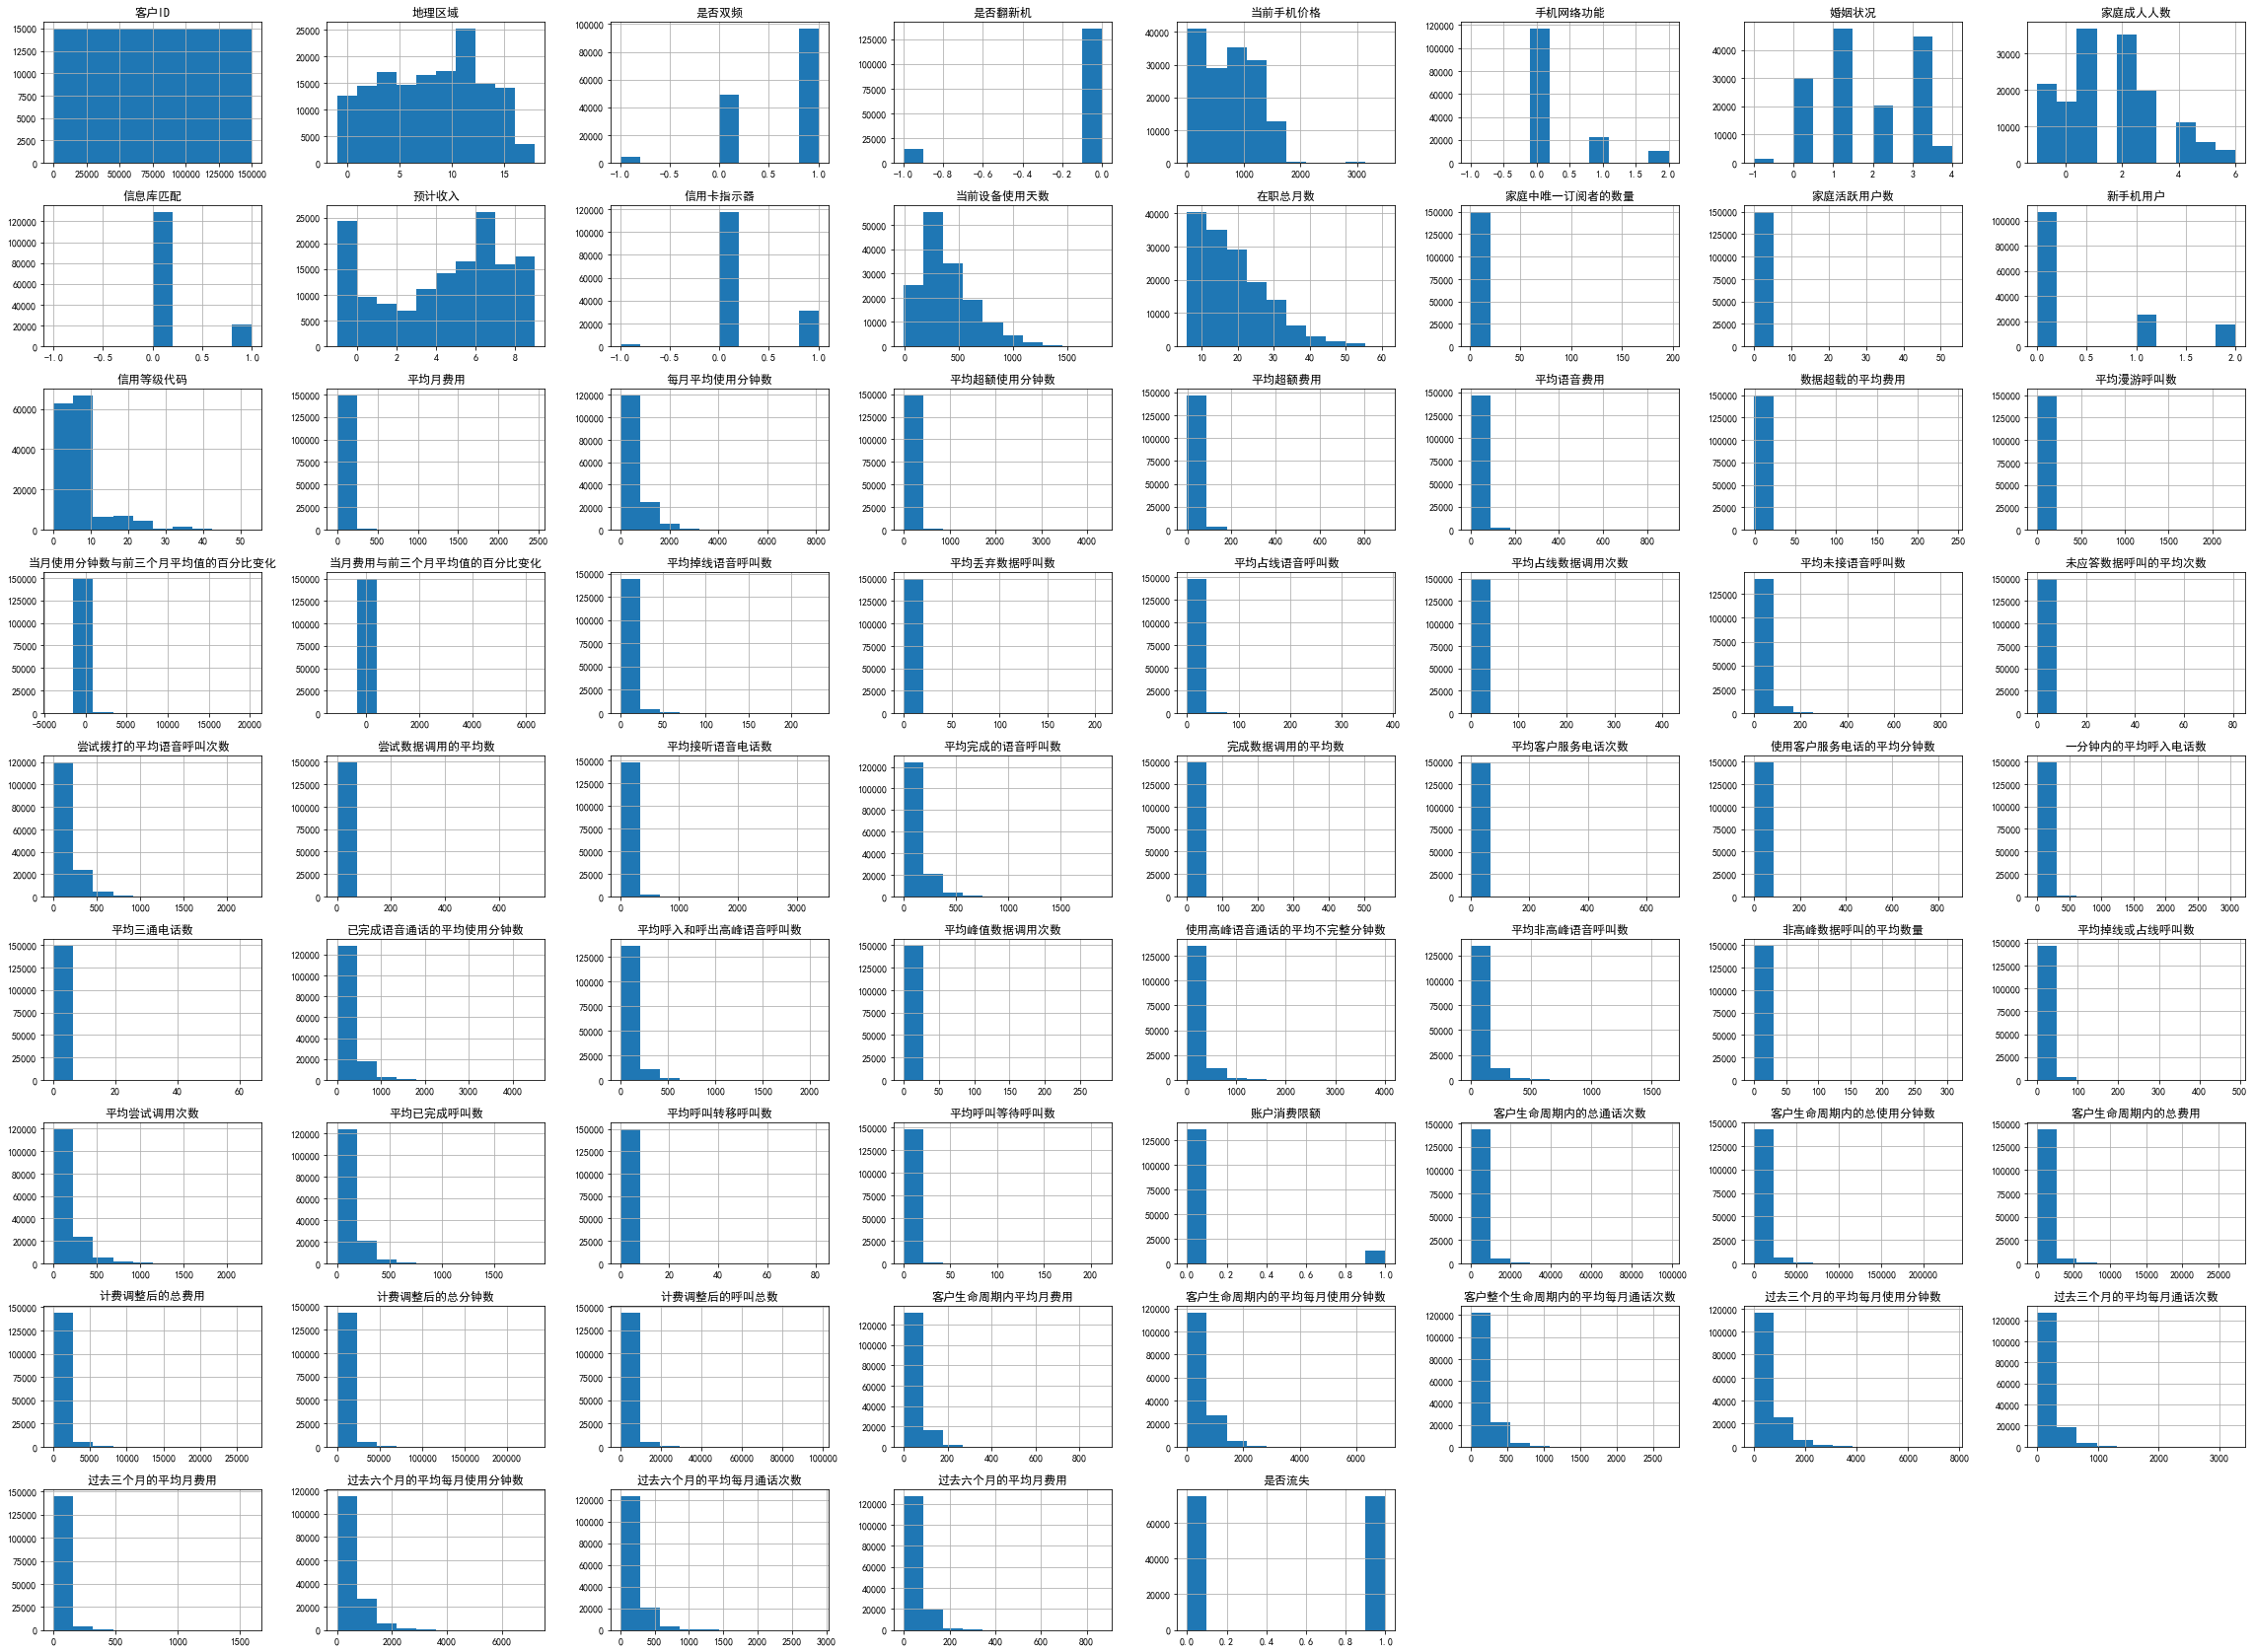

In [64]:
data_train.hist(bins=10, figsize=(40,30))
plt.show()

<AxesSubplot:xlabel='是否流失', ylabel='count'>

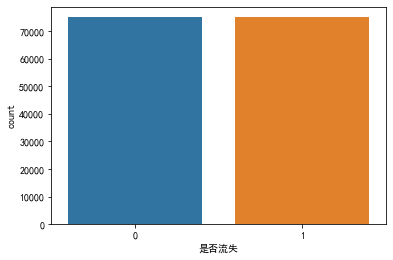

In [15]:
sns.countplot(x=data_train['是否流失'])

In [48]:
cat_ = ['地理区域', '是否双频', '是否翻新机', '手机网络功能', '婚姻状况', '家庭成人人数', '信息库匹配', '预计收入', '家庭活跃用户数', '新手机用户']

In [49]:
for _ in range(len(cat_)):
    print(data_train[cat_[_]].value_counts())

 12    14665
 11    10529
 7      9816
 13     8847
 9      8607
 4      8597
 10     8553
 3      8419
 5      7851
 15     7431
 2      7304
 0      7248
 1      7167
 6      6767
 8      6707
 16     6611
 14     6032
-1      5364
 17     3454
 18       31
Name: 地理区域, dtype: int64
 1    96874
 0    48990
-1     4136
Name: 是否双频, dtype: int64
 0    135857
-1     14143
Name: 是否翻新机, dtype: int64
 0    117129
 1     22281
 2     10408
-1       182
Name: 手机网络功能, dtype: int64
 1    47587
 3    44804
 0    30216
 2    20291
 4     5787
-1     1315
Name: 婚姻状况, dtype: int64
 1    36887
 2    35119
-1    21585
 3    19652
 0    16681
 4    11000
 5     5648
 6     3428
Name: 家庭成人人数, dtype: int64
 0    129210
 1     20609
-1       181
Name: 信息库匹配, dtype: int64
 6    26106
-1    24308
 5    16446
 7    15836
 4    14163
 3    11062
 0     9493
 9     9082
 8     8349
 1     8162
 2     6993
Name: 预计收入, dtype: int64
1     117893
2      27371
3       3562
4        799
5        204
0        138
6  

<AxesSubplot:xlabel='手机网络功能'>

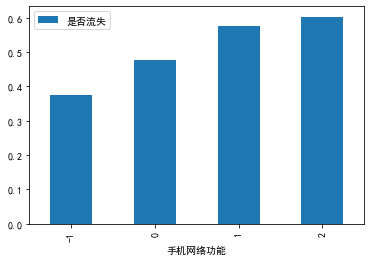

In [51]:
data_train[['是否流失','手机网络功能']].groupby(['手机网络功能']).mean().plot.bar()

<AxesSubplot:xlabel='是否双频'>

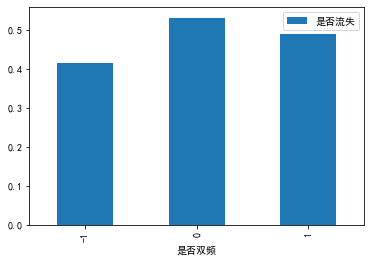

In [52]:
data_train[['是否流失','是否双频']].groupby(['是否双频']).mean().plot.bar()

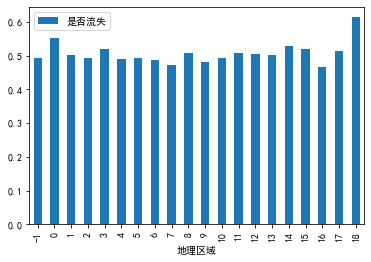

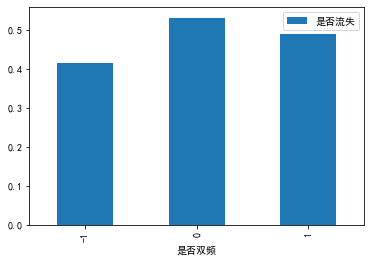

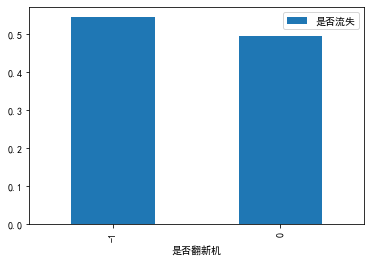

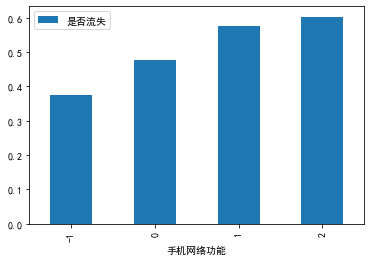

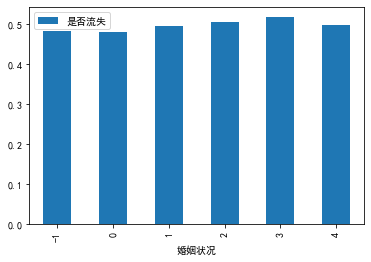

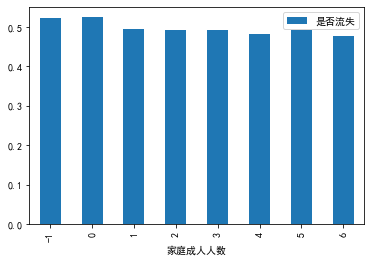

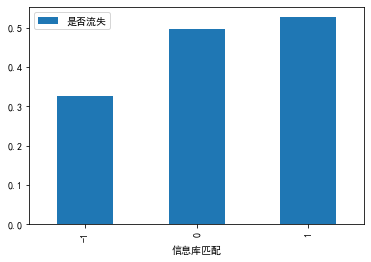

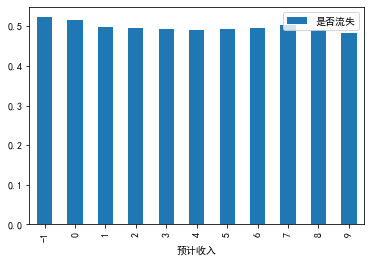

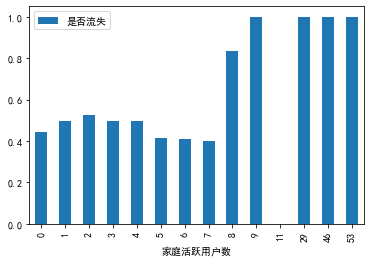

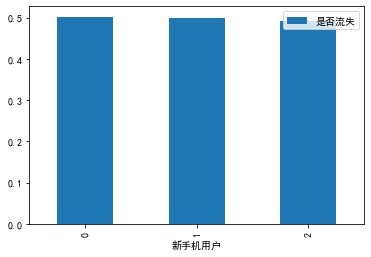

In [54]:
for _ in range(len(cat_)):
    data_train[['是否流失', cat_[_]]].groupby([cat_[_]]).mean().plot.bar()
plt.show()

In [57]:
import tensorflow as tf

In [58]:
# split the training data for model to train and test by 'Type'

from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.3, random_state=42)
strat_splits = []
for train_index, test_index in splitter.split(data_train, data_train['是否流失']):
    strat_train_set_n = data_train.loc[train_index]
    strat_test_set_n = data_train.loc[test_index]
    strat_splits.append([strat_train_set_n, strat_test_set_n])
strat_train_set, strat_test_set = strat_splits[0]
strat_train_set

,客户ID,地理区域,是否双频,是否翻新机,当前手机价格,手机网络功能,婚姻状况,家庭成人人数,信息库匹配,预计收入,...,客户生命周期内平均月费用,客户生命周期内的平均每月使用分钟数,客户整个生命周期内的平均每月通话次数,过去三个月的平均每月使用分钟数,过去三个月的平均每月通话次数,过去三个月的平均月费用,过去六个月的平均每月使用分钟数,过去六个月的平均每月通话次数,过去六个月的平均月费用,是否流失
120258,120258,13,1,0,559,0,3,-1,1,-1,...,37,291,82,273,81,32,316,93,40,1
65577,65577,6,1,0,909,0,2,1,0,0,...,96,1008,497,956,473,98,1001,501,91,1
70535,70535,13,1,0,1049,0,1,2,0,8,...,30,110,17,178,29,30,159,24,32,0
47480,47480,17,1,0,559,0,4,1,0,6,...,49,206,94,431,168,54,374,155,68,0
131146,131146,8,1,0,909,0,2,2,0,6,...,65,118,42,116,40,71,119,42,66,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27868,27868,12,1,-1,209,0,1,3,0,7,...,49,285,134,370,180,42,408,182,53,1
12022,12022,16,0,0,909,0,2,-1,1,-1,...,48,616,254,557,215,49,607,242,49,0
51616,51616,12,0,0,1399,0,3,1,0,4,...,166,1223,379,1607,453,213,1417,435,231,1
120687,120687,2,1,0,419,0,3,-1,1,-1,...,39,179,45,352,73,42,285,64,40,0


In [59]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dropout(.1),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(.1),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dropout(.1),    
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [60]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [62]:
X_train = strat_train_set.iloc[:, 1:68]
y_train = strat_train_set['是否流失']
X_train

,地理区域,是否双频,是否翻新机,当前手机价格,手机网络功能,婚姻状况,家庭成人人数,信息库匹配,预计收入,信用卡指示器,...,计费调整后的呼叫总数,客户生命周期内平均月费用,客户生命周期内的平均每月使用分钟数,客户整个生命周期内的平均每月通话次数,过去三个月的平均每月使用分钟数,过去三个月的平均每月通话次数,过去三个月的平均月费用,过去六个月的平均每月使用分钟数,过去六个月的平均每月通话次数,过去六个月的平均月费用
120258,13,1,0,559,0,3,-1,1,-1,1,...,995,37,291,82,273,81,32,316,93,40
65577,6,1,0,909,0,2,1,0,0,0,...,9177,96,1008,497,956,473,98,1001,501,91
70535,13,1,0,1049,0,1,2,0,8,1,...,322,30,110,17,178,29,30,159,24,32
47480,17,1,0,559,0,4,1,0,6,0,...,1884,49,206,94,431,168,54,374,155,68
131146,8,1,0,909,0,2,2,0,6,1,...,254,65,118,42,116,40,71,119,42,66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27868,12,1,-1,209,0,1,3,0,7,0,...,4164,49,285,134,370,180,42,408,182,53
12022,16,0,0,909,0,2,-1,1,-1,0,...,2106,48,616,254,557,215,49,607,242,49
51616,12,0,0,1399,0,3,1,0,4,0,...,4057,166,1223,379,1607,453,213,1417,435,231
120687,2,1,0,419,0,3,-1,1,-1,1,...,1008,39,179,45,352,73,42,285,64,40


In [63]:
history = model.fit(X_train, y_train, batch_size=2500, epochs=50, validation_split=0.2)
model.summary()

Epoch 1/50
34/34 [==============================] - 1s 6ms/step - loss: 130.3299 - accuracy: 0.5049 - val_loss: 46.0096 - val_accuracy: 0.5151
Epoch 2/50
34/34 [==============================] - 0s 2ms/step - loss: 71.4465 - accuracy: 0.5100 - val_loss: 26.2649 - val_accuracy: 0.5267
Epoch 3/50
34/34 [==============================] - 0s 3ms/step - loss: 34.7610 - accuracy: 0.5170 - val_loss: 10.4183 - val_accuracy: 0.5201
Epoch 4/50
34/34 [==============================] - 0s 3ms/step - loss: 15.3589 - accuracy: 0.5043 - val_loss: 2.1268 - val_accuracy: 0.4934
Epoch 5/50
34/34 [==============================] - 0s 3ms/step - loss: 9.1845 - accuracy: 0.5048 - val_loss: 1.3002 - val_accuracy: 0.4875
Epoch 6/50
34/34 [==============================] - 0s 3ms/step - loss: 6.8712 - accuracy: 0.4990 - val_loss: 1.1066 - val_accuracy: 0.4904
Epoch 7/50
34/34 [==============================] - 0s 3ms/step - loss: 5.1272 - accuracy: 0.5002 - val_loss: 1.0147 - val_accuracy: 0.4971
Epoch 8/50
3

In [ ]:
train_data.info()
print("-" * 40)
test_data.info()


In [ ]:
train_data.head()

In [69]:
from sklearn.metrics import roc_auc_score

y_true = np.array([0, 0, 1, 1, 1])
y_scores = np.array([0.1, 0.4, 0.35, 0.8, 0.7])

roc_auc_score(y_true, y_scores)

0.8333333333333333